We are an analyst at a big online store. Together with the marketing department, we've compiled a list of hypotheses that may help boost revenue. We need to prioritize these hypotheses, launch an A/B test, and analyze the results.

In [1]:
# Loading all the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from scipy import stats 
import matplotlib_inline.backend_inline
import math


## Please do not run the cell bellow. 

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

## Run from here.

In [3]:
# Loading the data files.

try:
  hypos = pd.read_csv("/content/drive/MyDrive/Practicum_data/hypotheses_us.csv", sep=';')#, parse_dates=['dt'])
except: 
  hypos = pd.read_csv("/datasets/hypotheses_us.csv", sep=';')

try:
  orders = pd.read_csv("/content/drive/MyDrive/Practicum_data/orders_us.csv")#, parse_dates=['Buy Ts'])
except: 
  orders = pd.read_csv("/datasets/orders_us.csv" )

try:
  visits = pd.read_csv("/content/drive/MyDrive/Practicum_data/visits_us.csv")#, parse_dates=['End Ts', "Start Ts"], dtype={'Device': 'category'} )
except: 
  visits = pd.read_csv("/datasets/visits_us.csv")

<div class="alert alert-block alert-success">
<b>Reviewer's comment v:</b>

Thanks for fixing that!

In [4]:
print("*********************************************")
print("****************** hypotheses ******************")
print("*********************************************")
print(" ")
hypos.info()
print(" ")
print("*********************************************")
print("**************** ORDERS *****************")
print("*********************************************")
print(" ")
orders.info()
print(" ")
print("*********************************************")
print("************** VISITS ***********************")
print("*********************************************")
print(" ")
visits.info()


*********************************************
****************** hypotheses ******************
*********************************************
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
 
*********************************************
**************** ORDERS *****************
*********************************************
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2

Let's print the hypothesis:

In [5]:
hypos.iloc[:, 0]

0    Add two new channels for attracting traffic. T...
1    Launch your own delivery service. This will sh...
2    Add product recommendation blocks to the store...
3    Change the category structure. This will incre...
4    Change the background color on the main page. ...
5    Add a customer review page. This will increase...
6    Show banners with current offers and sales on ...
7    Add a subscription form to all the main pages....
8    Launch a promotion that gives users discounts ...
Name: Hypothesis, dtype: object

Let's check NANS and duplicates:

In [6]:
print("There are", visits.isnull().sum().sum(), "nans in visits file ")
print("There are", orders.isnull().sum().sum(), "nans in orders file ")

There are 0 nans in visits file 
There are 0 nans in orders file 


In [7]:
print("There are", visits.duplicated(keep='first').sum(), "duplicates in visits_log file ")
print("There are", orders.duplicated(keep='first').sum(), "duplicates in orders_log file ")


There are 0 duplicates in visits_log file 
There are 0 duplicates in orders_log file 


We have 0 COMPLETE duplicates, but what if we have the same visitor IDs in both groups. We don't want that. 

Let's check if there are visitors that got into two groups A and B and get rid of them...

In [8]:
# First let's check how many unique visitorID are there in the orders:
orders.visitorId.nunique()

1031

In [9]:
# Then let's subgroup "groups", A and B
df_2_groups =  orders.groupby("group")

# Next then we split the df into two separate dfs
group_A = pd.DataFrame(df_2_groups.get_group('A'))
group_B = pd.DataFrame(df_2_groups.get_group('B'))
group_A.head()

,transactionId,visitorId,date,revenue,group
2,2961555356,4069496402,2019-08-15,10.2,A
7,2626614568,78758296,2019-08-15,20.1,A
8,1576988021,295230930,2019-08-15,215.9,A
10,3649131742,879864040,2019-08-15,65.7,A
12,2809384911,3213223594,2019-08-15,115.4,A


In [10]:
# Let's group the subgroups A and B again, this time by the visitorIDs. i.e. we want all the visits "shrink" to the number of visitors...
grouped_by_usersA = pd.DataFrame(group_A.groupby("visitorId"))
grouped_by_usersA.columns = ["visitorId", "info"]

grouped_by_usersB = pd.DataFrame(group_B.groupby("visitorId"))
grouped_by_usersB.columns = ["visitorId", "info"]
grouped_by_usersB["visitorId"].head(5)

0     5114589
1     6958315
2     8300375
3    39475350
4    47206413
Name: visitorId, dtype: int64

In [11]:
# Here we finnaly get the ids of the visitors that are assigned A AND B. We do this by merging the datasets on "inner". 
df_merge = pd.merge(grouped_by_usersA, grouped_by_usersB, on=["visitorId"], how='inner')["visitorId"]
len(df_merge)

58

Looks like there are 58 instances of visitors that are both A and B. Let's get rid of them:

In [12]:
# And get rid of these instances saving the rest in a new orders df

orders = orders[~orders.visitorId.isin(df_merge)]
orders.visitorId.nunique()

973

<div class="alert alert-block alert-success">
<b>Reviewer's comment v2:</b>
    
Well done! Great, that you identified these users. Indeed, having the same users in both groups contradicts the whole idea of A/B test.

We have cleaned our orders table from the visitors that were assigned to both the A and B groups. 1031 - 973 = 58 were dropped. 

*Another approach we could use is to asign these visitors to the group with the most [mode()] group instances. If someone is twice in group A and only once in group B, we would asign him to group A. We desided NOT to use this approach as it would create a logical problem: what do we do if an instance is asigned to both groups equal amount of times: twice to B and twice to A. Dropping these instances looks like the best solution...*

Our next task is:

*Apply the ICE framework to prioritize hypotheses. Sort them in descending order of priority.*

In [13]:
hypos.head(3)

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3


ICE framework states that the hypothsis should be avaluated based on a score 

ICE = (impact * confidence) / effort

In [14]:
hypos["ice_score"] = (hypos.Impact * hypos.Confidence)/hypos.Effort
hypos.sort_values(by = "ice_score", ascending = False)

,Hypothesis,Reach,Impact,Confidence,Effort,ice_score
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000
5,Add a customer review page. This will increase...,3,2,2,3,1.333333
3,Change the category structure. This will incre...,8,3,3,8,1.125000
4,Change the background color on the main page. ...,3,1,1,1,1.000000


Seems like the 8 hypothesis is most effective (by the ICE score). Followed by 0 and 7. 

Our next task is:

**Apply the RICE framework to prioritize hypotheses. Sort them in
descending order of priority**

In [15]:
hypos["rice_score"] = (hypos.Reach * hypos.Impact * hypos.Confidence)/hypos.Effort
hypos = hypos.sort_values(by = ["ice_score","rice_score"], ascending = False)
hypos

,Hypothesis,Reach,Impact,Confidence,Effort,ice_score,rice_score
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,16.2
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,112.0
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,40.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,4.0
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0


<div class="alert alert-block alert-warning">
<b>Reviewer's comment v2:</b>
    
Also you can add the following code to show all data in the table above: 
    
    pd.options.display.max_colwidth = 210

When we add a **Reach** factor into the equation - we get a different prioritazation of hypothesis. It happens mainly because our numerator (impact*confidince) is multiplied by one more factor, reach. 

Now the hypothesis that have larger REACH *(how many users will be impacted by the impementation)* gets highier priority. 

Let's see ICE and RICE scores on a graph:

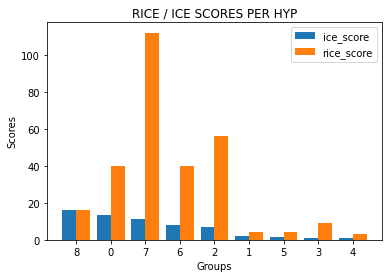

In [16]:
X_axis = np.arange(len(hypos))
  
plt.bar(X_axis - 0.2, hypos.ice_score, 0.4, label = 'ice_score')
plt.bar(X_axis + 0.2, hypos.rice_score, 0.4, label = 'rice_score')
  
plt.xticks(X_axis, hypos.index)
plt.xlabel("Groups")
plt.ylabel("Scores")
plt.title("RICE / ICE SCORES PER HYP")
plt.legend()
plt.show()

Since multiplication by Reach significantly changes our numerical means of RICE, much better approach to visualisation would be to first NORMALIZE our data. 

There are several way we can do this. Two the most comman are min/max normalization and zscore method. 

Let's use a zscore and plot our data again. 

In [17]:
from scipy.stats import zscore

hypos['ice_zscored'] = zscore(hypos['ice_score'])
hypos['rice_zscored'] = zscore(hypos['rice_score'])
hypos = hypos.sort_values(by = ["rice_zscored", "ice_zscored"], ascending = False)

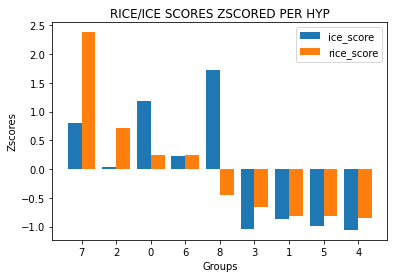

In [18]:
X_axis = np.arange(len(hypos))
  
plt.bar(X_axis - 0.2, hypos.ice_zscored, 0.4, label = 'ice_score')
plt.bar(X_axis + 0.2, hypos.rice_zscored, 0.4, label = 'rice_score')
  
plt.xticks(X_axis, hypos.index)
plt.xlabel("Groups")
plt.ylabel("Zscores")
plt.title("RICE/ICE SCORES ZSCORED PER HYP")
plt.legend()
plt.show()

Zscore uses the mean as a borderline. We see that 7 and 0 have the highiest values. Now let's try the minmax method:

Let's see what the minmax normalization has to say:


In [19]:
v = hypos["ice_score"] 
z = (v - v.min()) / (v.max() - v.min())
hypos["ice_minmaxed"] = z

r = hypos["rice_score"] 
b = (r - r.min()) / (r.max() - r.min())
hypos["rice_minmaxed"] = b


In [20]:
hypos = hypos.sort_values(by = ["rice_minmaxed", "ice_minmaxed"], ascending = False)

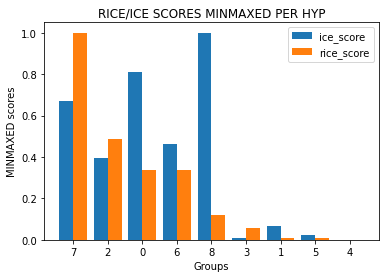

In [21]:
X_axis = np.arange(len(hypos))
  
plt.bar(X_axis - 0.2, hypos.ice_minmaxed, 0.4, label = 'ice_score')
plt.bar(X_axis + 0.2, hypos.rice_minmaxed, 0.4, label = 'rice_score')
  
plt.xticks(X_axis, hypos.index)
plt.xlabel("Groups")
plt.ylabel("MINMAXED scores")
plt.title("RICE/ICE SCORES MINMAXED PER HYP")
plt.legend()
plt.show()

Same results but calculated differently. 

Normalization od data allows us to see the relative "strenght" of the values from different groups.

<div class="alert alert-block alert-success">
<b>Reviewer's comment v2:</b>
    
Almost everything is correct here. You correctly applied `RICE` framework. And based on the results, it is clear now what is the impact of the reach factor on overall value.
    
Additionally you can create a scatter plot to map all numbers per hypothesis to compare them.

# Part 2. A/B Test Analysis

### *You carried out an A/B test and got the results described in the files orders_us.csv and visits_us.csv*.
### *1. Graph cumulative revenue by group. Make conclusions and conjectures.*

/tmp/ipykernel_72/589637157.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(year_labels)


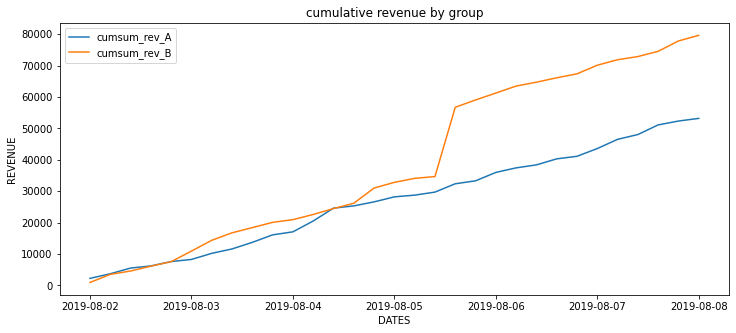

In [22]:
# First let's groupby "groups", A and B
df_2_groups =  orders.groupby("group")

# Now we split the df into two separate dfs
group_A = df_2_groups.get_group('A')
group_B = df_2_groups.get_group('B')

# We sum the revenues by dates
group_A = group_A.groupby(["date"]).agg({"revenue": "sum"}).reset_index()
group_B = group_B.groupby(["date"]).agg({"revenue": "sum"}).reset_index()

# And cumsum the results in a new table
group_A["cumsum_rev_A"] = group_A["revenue"].cumsum()
group_B["cumsum_rev_B"] = group_B["revenue"].cumsum()

# Then let's plot the results:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,5))
group_A["cumsum_rev_A"].plot(ax=ax)
group_B["cumsum_rev_B"].plot(ax=ax)
year_labels = group_A.date.values
ax.xaxis.set_ticklabels(year_labels)
plt.title("cumulative revenue by group")
plt.xlabel("DATES")
plt.ylabel("REVENUE")
plt.legend()
plt.show()


The graph above shows that unlike group A, that is steadily grows over time, group B experinces a "jump" in revenues. This is **not** due to a change in the oveall bussiness strategy, as the cumulative revenues of B **after** the "jump" remain in the same level of growth as group A. This means that we are having a very big order in group B. 

<div class="alert alert-block alert-success">
<b>Reviewer's comment v2:</b>
    
Very nice data visualization.

It is a matter of taste, but you can also use `plt.grid()` to add grid to your graph and rotate x-axis ticks.

### *2 Graph **cumulative average order size by group**. Make conclusions and conjectures.*

/tmp/ipykernel_72/2141295702.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(year_labels)


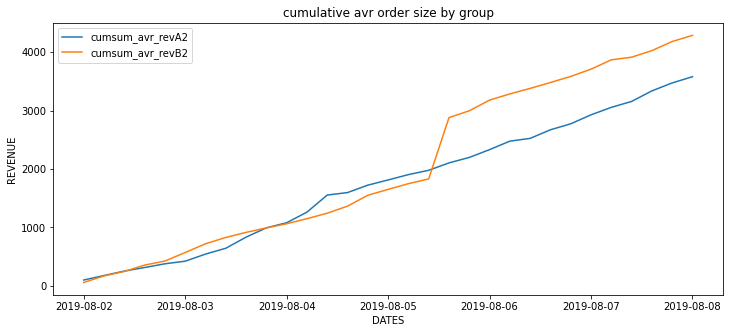

In [23]:
# Let's take the original clean data and split to A2 & B2
group_A2 = df_2_groups.get_group('A')
group_B2 = df_2_groups.get_group('B')

# We then group by dates and agg by the mean of rev (NOT sum as prev.)
group_A2 = group_A2.groupby(["date"]).agg({"revenue": "mean"}).reset_index()
group_B2 = group_B2.groupby(["date"]).agg({"revenue": "mean"}).reset_index()

# We create a new col wt the avr revs cumsumed
group_A2["cumsum_avr_revA2"] = group_A2["revenue"].cumsum()
group_B2["cumsum_avr_revB2"] = group_B2["revenue"].cumsum()

# and plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,5))
group_A2["cumsum_avr_revA2"].plot(ax=ax)
group_B2["cumsum_avr_revB2"].plot(ax=ax)
year_labels = group_A2.date.values
ax.xaxis.set_ticklabels(year_labels)
plt.title("cumulative avr order size by group")
plt.xlabel("DATES")
plt.ylabel("REVENUE")
plt.legend()
plt.show()


The graph of avr order size by group repeats the same dinamic of cumulative revenue by group graph. There's a big order that shifts the mean of orders up. Let's explore this order a little deeper. Let's plot the revenues of group B using a bar chart.  

<div class="alert alert-block alert-success">
<b>Reviewer's comment v2:</b>
    
Once again everything is correct here and the same comments as above.

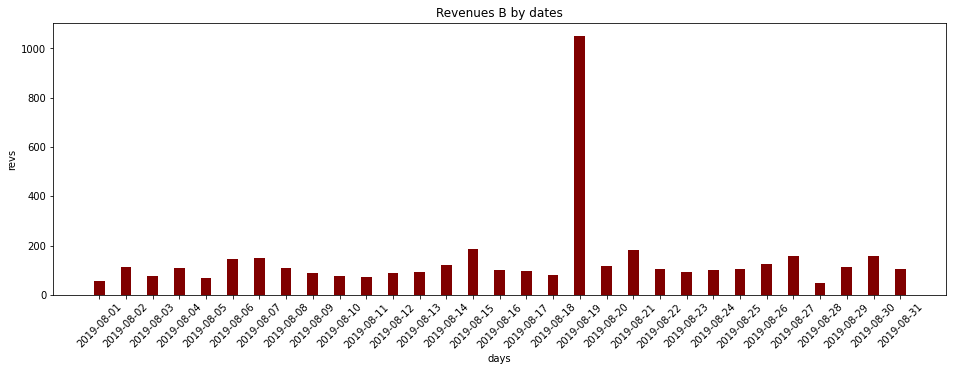

In [24]:

dts = list(group_B2.date)
revs = list(group_B2["revenue"])
  
fig = plt.figure(figsize = (16, 5))
 
# creating the bar plot
plt.bar(dts, revs, color ='maroon',
        width = 0.4)
plt.tick_params(axis='x', rotation=45)
plt.xlabel("days")
plt.ylabel("revs")
plt.title("Revenues B by dates")
plt.show()

On 18.08.2019 there was a very big order. The day after the daily revenue dropped back to the normal level. 

If we ignore the spike in the revs, the bar chart showes another interesting feature of group B: There's a **weekly pattern** that repeats throught these 31 days: the daily revenues go up and down in a **wave like form**. This is something that we couldn't discover using our previous charts. What this wave form means? It means that the daily rev of this group demonstrate predictability. We can say with a certain confidence that on weekdays the revs are lower than weekends. We can even calculate our confidence AND the expected weekends avr level based on the avr historical and avr mid-week level.

Let's see if we can find something similiar in group A:

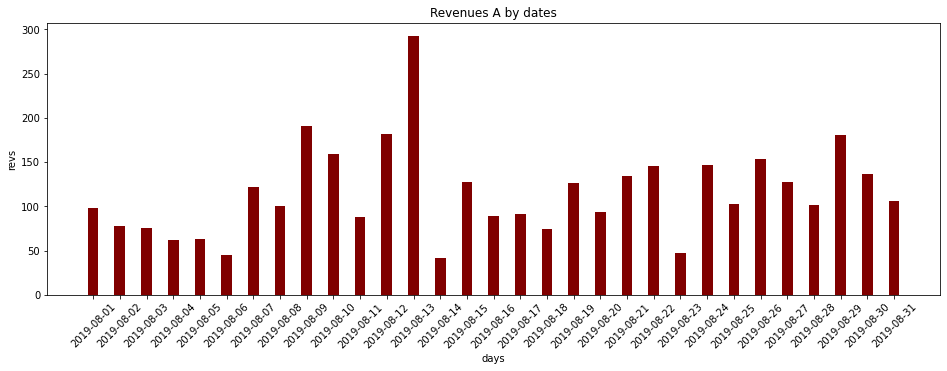

In [25]:

dts = list(group_A2.date)
revs = list(group_A2["revenue"])
  
fig = plt.figure(figsize = (16, 5))
 
# creating the bar plot
plt.bar(dts, revs, color ='maroon',
        width = 0.4)
plt.tick_params(axis='x', rotation=45)
plt.xlabel("days")
plt.ylabel("revs")
plt.title("Revenues A by dates")
plt.show()

The wave pattern in Group A **is not as distinct** as with the group B. Meaning Group B is more predictable in it's behavior. 

## *3. Graph the **relative difference in cumulative average order size** for group B compared with group A. Make conclusions and conjectures.*



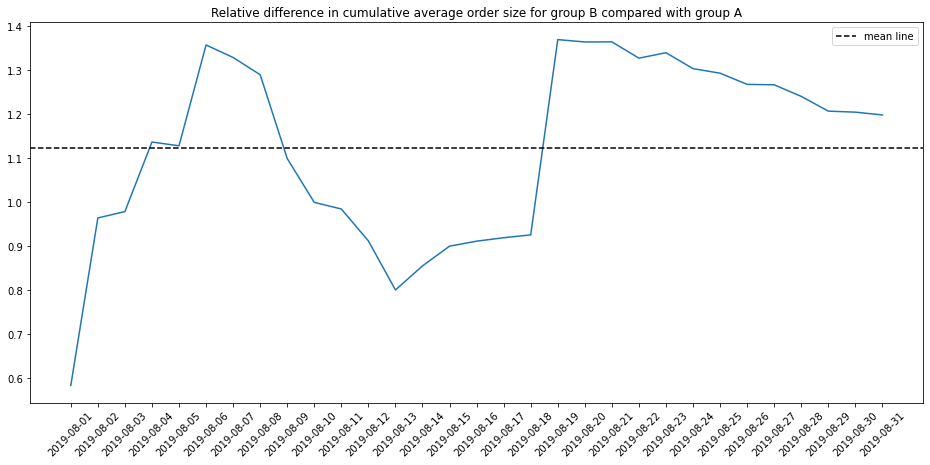

In [26]:
# We will need just two columns from the Group A:
new = group_A2[["cumsum_avr_revA2", "date"]]


# gathering the data into one DataFrame
merged_avr_cumulative_size = new.merge(group_B2, left_on='date', right_on='date', how='inner', suffixes=['A', 'B'])

# plotting a relative difference graph for the average purchase sizes
plt.figure(figsize = (16,7))
plt.plot(merged_avr_cumulative_size['date'], (merged_avr_cumulative_size['cumsum_avr_revB2']/(merged_avr_cumulative_size['cumsum_avr_revA2'] - 1) ))
mean_line = (merged_avr_cumulative_size['cumsum_avr_revB2']/(merged_avr_cumulative_size['cumsum_avr_revA2'] - 1) ).mean() 

# adding the X axis and legend
plt.axhline(y=mean_line, color='black', linestyle='--', label = "mean line") 
plt.tick_params(axis='x', rotation=45)
plt.title("Relative difference in cumulative average order size for group B compared with group A")
plt.legend()
plt.show()

We see that the ratio bt avr order size of the the groups changes significantly throught the period. Group B starts 50% bellow the mean but in just 5 days moves above the mean and gains almost 30% more than A. It then shaply drops and regains it's advantage on a day of a big order (18.8). Curently B metrics are 12% higher than A. 

The graph of the difference in average purchase size shows fluctuations: This graph allows us to detect anomalies but we can't draw any definite conclusions from this graph. We can say that **visually**, the differences between the groups are distinct.  

<div class="alert alert-block alert-success">
<b>Reviewer's comment v2:</b>
    
Indeed, it could be helpful to study data without outliers. Also, interesting to note that difference has been stabilized in the last couple of days.

##4. *Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures.*

/tmp/ipykernel_98/1890234299.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(year_labels)


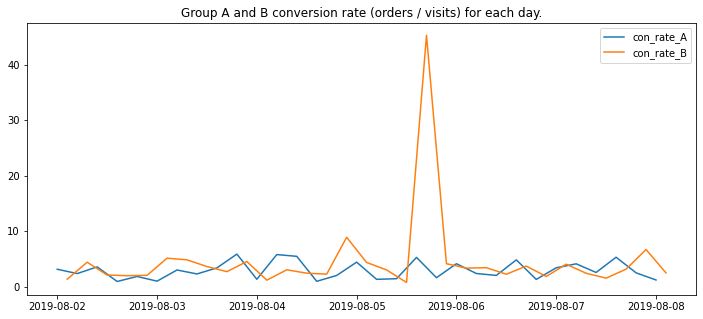

In [27]:
# Taking care of visits
convertion_table = visits.groupby(["date", "group"]).agg({"visits": "sum"}).reset_index()
convertion_table = convertion_table.merge(group_A)

#roup_B2, left_on='date', right_on='date', how='left', suffixes=['A',' 'B])

# Error handler
pd.options.mode.chained_assignment = None

# Taking care of orders
ords = orders.groupby(["date", "group"]).agg({"revenue": "sum"}).reset_index()

convertion_table = convertion_table.merge(ords, left_on=['date', "group"],right_on= ['date', "group"], how='outer', suffixes=['A', 'B'])

convertion_table_A = convertion_table.query('group == "A"')
convertion_table_B = convertion_table.query('group == "B"')

convertion_table_A["con_rate_A"] = convertion_table_A.revenueA / convertion_table_A.visits
convertion_table_B["con_rate_B"] = convertion_table_B.revenueB / convertion_table_B.visits

# and plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,5))
convertion_table_A["con_rate_A"].plot(ax=ax)
convertion_table_B["con_rate_B"].plot(ax=ax)
year_labels = convertion_table_A.date.values
ax.xaxis.set_ticklabels(year_labels)
plt.title("Group A and B conversion rate (orders / visits) for each day.")
plt.legend()
plt.show()



<div class="alert alert-block alert-warning">
<b>Reviewer's comment v2:</b>
    
Nice plot with conversion and conclusions. 
    
However, additionally could be interesting to plot a relative difference graph for the cumulative conversion rates, as based on the graph above it is difficult to say smth about data stability and which group has higher conversion rate.

##5. *Plot a scatter chart of the **number of orders per user**. Make conclusions and conjectures.*

I think it would be more informative to plot this chart by groups too...

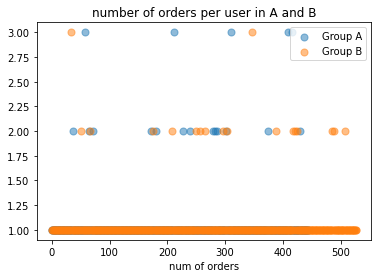

In [28]:
import matplotlib.transforms as transforms


# First let's groupby "groups", A and B
df_2_groups_new =  orders.groupby("group")

# Here we split the df into two separate dfs
group_A = df_2_groups_new.get_group('A')
group_B = df_2_groups_new.get_group('B')

group_A = group_A.groupby(["visitorId"]).agg({'transactionId' : pd.Series.nunique}).reset_index()
group_B = group_B.groupby(["visitorId"]).agg({'transactionId' : pd.Series.nunique}).reset_index()

group_A.columns = ["visitorId", "num_orders_A"]
group_B.columns = ["visitorId", "num_orders_B"]


x_valuesA = pd.Series(range(0, len(group_A['visitorId'])))
labelA = "Group A"
plt.scatter(x_valuesA, group_A['num_orders_A'], alpha = 0.5, s= 50,label = labelA)

x_valuesB = pd.Series(range(0, len(group_B['visitorId'])))
labelB = "Group B"
plt.scatter(x_valuesB, group_B['num_orders_B'], alpha = 0.5, s=50, label = labelB)
plt.xlabel("instances")
plt.xlabel("num of orders")
plt.title("number of orders per user in A and B")
plt.legend()
plt.show()

The graph above shows that the vast majority of users in both groups are one time users. Rarely do they buy twice. And on a very rare ocassions they buy 3 times. With that said, Group A users tend to buy 3 orders 2.5 times more than Group B. We see this on a graph or by a calculation:

In [29]:
group_A[group_A["num_orders_A"] ==3].count() / group_B[group_B["num_orders_B"] ==3].count()


num_orders_A    NaN
num_orders_B    NaN
visitorId       2.5
dtype: float64

## 6. *Calculate the **95th and 99th percentiles** for the number of orders per user. Define the point at which a data point becomes an anomaly.*

In [30]:
print("For Group A, the 95, 99 percentiles are", np.percentile(group_A['num_orders_A'], [95, 99])) 
print("For Group B, the 95, 99 percentiles are", np.percentile(group_B['num_orders_B'], [95, 99])) 

For Group A, the 95, 99 percentiles are [1.   2.56]
For Group B, the 95, 99 percentiles are [1. 2.]


Group A have a higher 99 percentile than Group B, since, as we know from our previous calculations Group A tends to buy 3 orders per user 2.5 times more than Group B. We confirm this again by a highier 99 percentile (2.56). With that said, for BOTH groups, 3 orders per user is an anomaly, if we defina anomaly as a 1% of our data. If we define anomaly as 5% likelihood, then 2 orders per user are falling into the anomaly zone, and this is true for both groups. 

##7 *Plot a **scatter chart of order prices**. Make conclusions and conjectures.*

We decided to plot Group A and Group B seperatly:

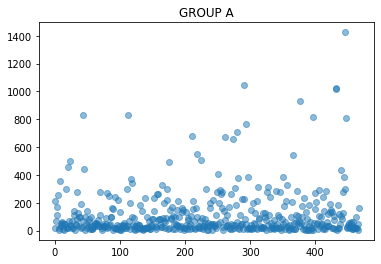

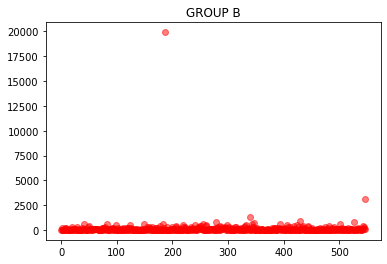

In [31]:
group_A = df_2_groups_new.get_group('A')
group_B = df_2_groups_new.get_group('B')

# A
x_values_A = pd.Series(range(0, len(group_A['visitorId'])))
plt.scatter(x_values_A, group_A['revenue'], alpha = 0.5) 
plt.title("GROUP A")
plt.show()

# B
x_values_B = pd.Series(range(0, len(group_B['visitorId'])))
plt.scatter(x_values_B, group_B['revenue'], alpha = 0.5, color = "red") 
plt.title("GROUP B")
plt.show()

The 20000$ order skews the table of Group B and squizes 99% of the data. Let's cut it off...

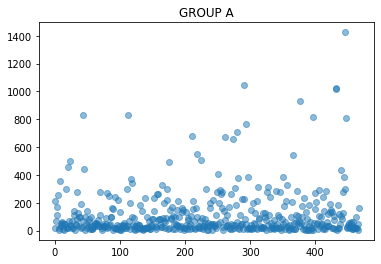

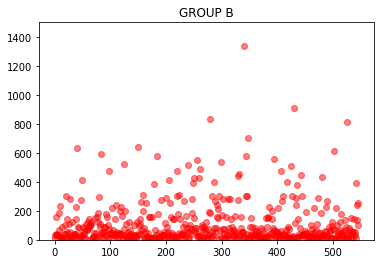

In [32]:
# A
x_values_A = pd.Series(range(0, len(group_A['visitorId'])))
plt.scatter(x_values_A, group_A['revenue'], alpha = 0.5) 
plt.title("GROUP A")
plt.show()

x_values_B = pd.Series(range(0, len(group_B['visitorId'])))
plt.scatter(x_values_B, group_B['revenue'], alpha = 0.5, color = "red") 
plt.ylim(0, 1500)
plt.title("GROUP B")
plt.show()

**Visually** we can **not** draw a definitive conclution regarding the differences between the two groups. The order prices between 0 and 1400 seems alike in both groups. Let's inspect the orders between 800 and 3000

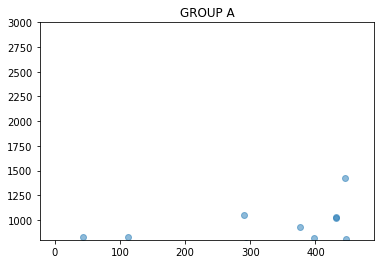

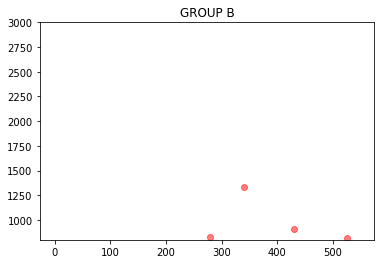

In [33]:
# A
x_values_A = pd.Series(range(0, len(group_A['visitorId'])))
plt.scatter(x_values_A, group_A['revenue'], alpha = 0.5) 
plt.ylim(800, 3000)
plt.title("GROUP A")
plt.show()

x_values_B = pd.Series(range(0, len(group_B['visitorId'])))
plt.scatter(x_values_B, group_B['revenue'], alpha = 0.5, color = "red") 
plt.ylim(800, 3000)
plt.title("GROUP B")
plt.show()

Group A has twice as much orders in a 800-1750 range than Group B. (8 vs 4)

<div class="alert alert-block alert-success">
<b>Reviewer's comment v2:</b>
    
Great scaterplots. Additionally you can color two groups on this graph using other 'hue' parameter (https://seaborn.pydata.org/generated/seaborn.scatterplot.html) or different data sources (https://moonbooks.org/Articles/How-to-create-a-scatter-plot-with-several-colors-in-matplotlib-/)

## 8 . *Calculate the **95th and 99th** percentiles of order prices. Define the point at which a data point becomes an anomaly.*

We decided to calc the percentiles for each group:

In [34]:
print("For Group A the percentiles are", np.percentile(group_A['revenue'], [ 95, 99])) 
print("For Group B the percentiles are", np.percentile(group_B['revenue'], [ 95, 99])) 


For Group A the percentiles are [385.63  863.201]
For Group B the percentiles are [425.795 763.865]


We define anomaly as likelihood thet the price is higher than 99% of the data. 

For Group A the anomolous price is any price above 863. 
For Group B, it is any price above 763. 

<div class="alert alert-block alert-success">
<b>Reviewer's comment v2:</b>
    
You correctly identified 95th and 99th percentiles of order prices. Now you have a threshold and data could be filtered.

## 9. *Find the statistical significance of the **difference in conversion** between the groups using the **raw data**. Make conclusions and conjectures.*

In [35]:
#let's import the orders data as orders_raw


orders_raw = pd.read_csv("/datasets/orders_us.csv")

In [36]:
#Organizing group A
ordersByUsersA = orders_raw[orders_raw['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'num_orders_A']

##Organizing group A
ordersByUsersB = orders_raw[orders_raw['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'num_orders_B']

# Creating samples A & B
sampleAraw = pd.concat([ordersByUsersA['num_orders_A'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['num_orders_A'])))],axis=0)
sampleBraw = pd.concat([ordersByUsersB['num_orders_B'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['num_orders_B'])))],axis=0)

print("P_VALUE:", "{0:.3f}".format(stats.mannwhitneyu(sampleAraw, sampleBraw)[1]))

print("RELATIVE DIFF RATIO:", "{0:.3f}".format(sampleBraw.mean()/sampleAraw.mean()-1)) 

P_VALUE: 0.017
RELATIVE DIFF RATIO: 0.138


When using the raw data, our p_value is lower than 0.05%, and therefore we find evidence to reject the null hypothesis. We find evidence that support the hypothesis that the two groups are different. We also know by how much their samples means were different: by 13.8%


#10. *Find the statistical significance of the difference in **average order size** between the groups using the **raw data**. Make conclusions and conjectures.*

To calculate the statistical significance of the difference in the two groups average order size, we'll pass the data on revenue to the mannwhitneyu() criterion.
We'll also find the relative difference in average order size between the groups:


In [37]:
import scipy.stats as stats


In [38]:
print( "p-value:", '{0:.3f}'.format(stats.mannwhitneyu(orders_raw[orders_raw['group']=='A']['revenue'], orders_raw[orders_raw['group']=='B']['revenue'])[1]))
print("Relative difference in average order size:",'{0:.3f}'.format(orders_raw[orders_raw['group']=='B']['revenue'].mean()/orders_raw[orders_raw['group']=='A']['revenue'].mean()-1)) 

p-value: 0.692
Relative difference in average order size: 0.252


Оur p_value (based on a **structural approach**, or a **nonparametric** test of a data called mannwhitneyu() method) is highier than 0.05. By alot!

We know that our **raw** data contains a outlier in revenues of Group B. If we would apply the usual parametric approach, our p_value would be influenced by the outliers. But the nonparametric method mannwhitneyu() calculates the p_value while ignoring the outliers, thus our final result is deep into the null hyp terrotory, meaning **we can not reject** the null hyp that states that the two groups have similiar average order size. 

The relative difference between the raw sets is 25%

#11. *Find the statistical significance of the **difference in conversion** between the groups using the **filtered data**. Make conclusions and conjectures.*



In [39]:
#Organizing group A
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'num_orders_A']

##Organizing group A
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'num_orders_B']

# Creating samples A & B
sampleA = pd.concat([ordersByUsersA['num_orders_A'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['num_orders_A'])))],axis=0)
sampleB = pd.concat([ordersByUsersB['num_orders_B'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['num_orders_B'])))],axis=0)

print("P_VALUE:", "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("RELATIVE DIFF RATIO:", "{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

P_VALUE: 0.011
RELATIVE DIFF RATIO: 0.160


Previously, when we used the raw data, our results were:
P_VALUE: 0.008
RELATIVE DIFF RATIO: 0.138

Our p_value was lower than 0.05%,we rejected the null hypothesis and found evidence that the two groups are different( by 13.8%)

Now, using the filtered data, we see that the difference between the group samples is larger, that previously found: 

The filtered P VALUE is 0.011
and relative diff ratio of means is 0.16

Meaning that the filtered samples A and B are MORE heterogeneous (diverse) than the raw data, and the diff ratio of means (B.mean / A.mean) is 16%. 

<div class="alert alert-block alert-success">
<b>Reviewer's comment v2:</b>
    
Great job! Hypotheses have been formulated and tested correctly. 

# 12. *Find the statistical significance of the **difference in average order size** between the groups using the **filtered data**. Make conclusions and conjectures.*

In [40]:
print( "p-value:", '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("Relative difference in average order size (filtered):",'{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.862
Relative difference in average order size (filtered): 0.278


Let's see the overall results of our test:




In [41]:

print("Convertion rate p_value of raw_data is",  "{0:.3f}".format(stats.mannwhitneyu(sampleBraw, sampleAraw)[1]))
print("Convertion rate of filtered data is", "{0:.3f}".format(stats.mannwhitneyu( sampleB, sampleA)[1]))
print(" ")
print("Group B mean of convertion is by",  "{0:.3f}".format(sampleBraw.mean()/sampleAraw.mean()-1), "% higher than A in raw data")
print("Group B mean of convertion is by", "{0:.3f}".format(sampleB.mean()/sampleA.mean()-1), "% higher than A in filtered data")
print(" ")
print("Avr order size p_value in raw data is",'{0:.3f}'.format(stats.mannwhitneyu(orders_raw[orders_raw['group']=='A']['revenue'], orders_raw[orders_raw['group']=='B']['revenue'])[1]),
      "and ijn filtered", '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1], ))
print(" ")
print("Group B mean of order size in raw_data is by",  '{0:.3f}'.format(orders_raw[orders_raw['group']=='B']['revenue'].mean()/orders_raw[orders_raw['group']=='A']['revenue'].mean()-1), "bigger than group A" )
print("Group B mean of order size in filtered_data is by",'{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1),
    "bigger than group A")

Convertion rate p_value of raw_data is 0.017
Convertion rate of filtered data is 0.011
 
Group B mean of convertion is by 0.138 % higher than A in raw data
Group B mean of convertion is by 0.160 % higher than A in filtered data
 
Avr order size p_value in raw data is 0.692 and ijn filtered 0.862
 
Group B mean of order size in raw_data is by 0.252 bigger than group A
Group B mean of order size in filtered_data is by 0.278 bigger than group A



There's a statistically significant difference in conversion between the groups, in both the raw **and** the filtered data. And as we filtered the data the difference between the groups is more distinct (on the convertion rate) it grows from 13% to 16% difference of B over A.  

Yet the raw and filtered data didn't show a statistically significant difference between the groups in terms of **average purchase size**. 
Filtered data merly fine tuned what we already knew: the avr order size in both groups is similiar (resulted p_value is way above 5%).

Meaning that in one of the groups the visitors convert better(earlier) but they do not  (necessarily) buy more per user. 

For our business model the KPI is the **convertion** rate. 
Therefore we stop the test and declare the B group as a leader. 

<div class="alert alert-block alert-success">
<b>Reviewer's comment v2</b> 

Great that you wrote about all important steps and findings in your project. 
 
And overall, you conducted great research with correct interim findings, clean code and nice visualization.
    
One comment about running the test is that we can mistakenly wait till the moment we get correct results (to face a peeking problem). 
    
You can check an article about it here: https://gopractice.io/blog/peeking-problem/#:~:text=by%20Oleg%20Yakubenkov-,Peeking%20problem%20%E2%80%93%20the%20fatal%20mistake%20in%20A%2FB%20testing%20and,A%2FB%20test%20is%20over
    
</div>